In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -q kagglecatsanddogs_3367a.zip
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  7981k      0  0:01:40  0:01:40 --:--:-- 8188k 0:01:42  0:01:05  0:00:37 6411k
 Cat_vs_Dog.ipynb   kagglecatsanddogs_3367a.zip   PetImages
 Demo		   'MSR-LA - 3467.docx'		 'readme[1].txt'


In [3]:
!ls PetImages

Cat  Dog


### Delete corrupted images

In [4]:
num_skipped = 0
for folder_name in ("Cat","Dog"):
    folder_path = os.path.join("PetImages",folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path,fname)
        try:
            fobj = open(fpath,"rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
            
        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)
            
print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [5]:
image_size = (180,180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


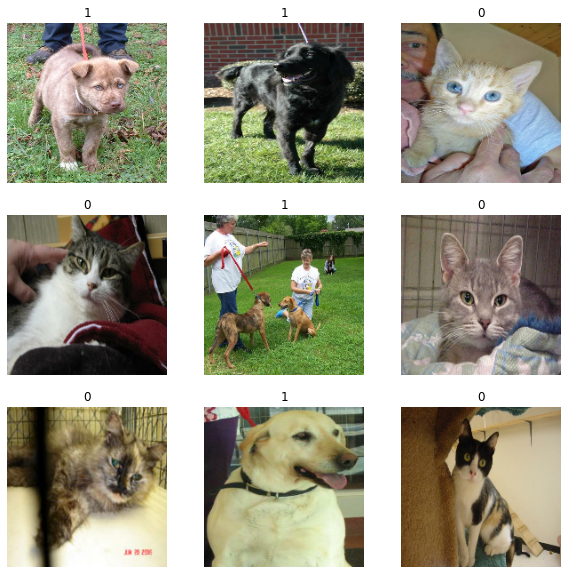

In [6]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
])

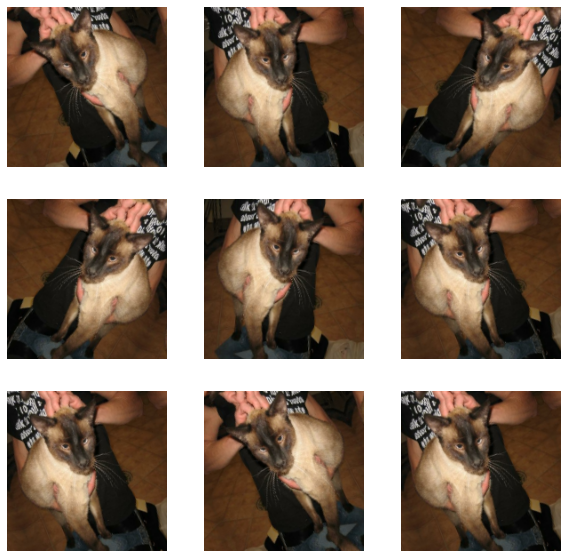

In [8]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [10]:
num_classes = 2

model = tf.keras.models.Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(512,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(1024,activation='relu'),
    layers.Dense(num_classes)
])

In [11]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [12]:
model.fit(train_ds,epochs=50,validation_data=val_ds)

Epoch 1/50
586/586 [==============================] - 51s 81ms/step - loss: 0.6954 - accuracy: 0.5184 - val_loss: 0.6728 - val_accuracy: 0.5991
Epoch 2/50
586/586 [==============================] - 47s 80ms/step - loss: 0.6608 - accuracy: 0.6051 - val_loss: 0.6282 - val_accuracy: 0.6271
Epoch 3/50
586/586 [==============================] - 48s 81ms/step - loss: 0.6058 - accuracy: 0.6703 - val_loss: 0.5535 - val_accuracy: 0.7234
Epoch 4/50
586/586 [==============================] - 48s 82ms/step - loss: 0.5604 - accuracy: 0.7126 - val_loss: 0.5228 - val_accuracy: 0.7443
Epoch 5/50
586/586 [==============================] - 49s 83ms/step - loss: 0.5086 - accuracy: 0.7495 - val_loss: 0.4565 - val_accuracy: 0.7826
Epoch 6/50
586/586 [==============================] - 48s 82ms/step - loss: 0.4624 - accuracy: 0.7812 - val_loss: 0.4258 - val_accuracy: 0.8078
Epoch 7/50
586/586 [==============================] - 49s 83ms/step - loss: 0.4257 - accuracy: 0.8024 - val_loss: 0.3940 - val_accuracy:

### Making some prediction from random data that are not from the PetImages folder

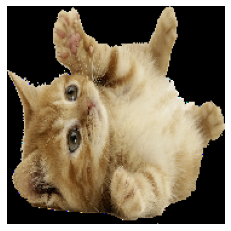

99.90 % that it is a cat




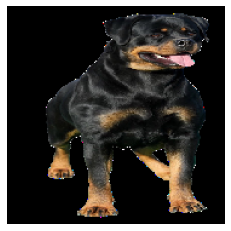

99.96 % that it is a dog




In [13]:
import numpy as np

data = {"Demo/cat.png","Demo/dog.png"}
for name in data:
    img = keras.preprocessing.image.load_img(name, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array,0)
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
    if(np.argmax(score)==0):
        print("{:.2f} % that it is a cat".format(100*np.max(score)))
        print("\n")
    elif(np.argmax(score)==1):
        print("{:.2f} % that it is a dog".format(100*np.max(score)))
        print("\n")